# Import packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Flatten, Bidirectional, TimeDistributed, Dropout, BatchNormalization, GRU, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import log_loss
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# colab 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load Data 

In [ ]:
# jupyter 
df_merge = pd.read_csv("/home/fshokor/Desktop/Uni/coursprog/RAPMC/datas/all_data_clean.txt",sep="\|\|", engine="python")
df_merge.head()

In [ ]:
# colab
df_merge = pd.read_csv("/content/gdrive/MyDrive/Kaggle/datas/all_data_clean.txt",sep="\|\|", engine="python")
df_merge.head()

,ID,Gene,Variation,Class,Text,Score
0,0,FAM58A,truncating mutations,1,"here, we deorphanize cdk10 by identifying cyc...",2
1,1,CBL,w802*,2,the c-cbl loh also positively correlated wit...,1
2,2,CBL,q249e,2,the c-cbl loh also positively correlated wit...,1
3,3,CBL,n454d,3,"most of the changes were novel, although 4 c...",1
4,4,CBL,l399v,4,all mutations from the second group were pre...,1


In [ ]:
df_merge.shape

(3316, 6)

In [ ]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
  # lowercase text
  data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
  # remove numeric values
  data = data.str.replace("\d","")
  # remove punctuations
  data = data.str.replace("[^\w\s]","")
  # remove stopwords: the,a,an etc.
  data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
  return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_merge['Text']= pre_processing(df_merge['Text'])

# Text tokenizer

In [ ]:
# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency.
num_words = 700 
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_merge['Text'].values) # Updates internal vocabulary based on a list of texts.

In [ ]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_merge['Text'].values) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=700) # transforms a lists of integers into a 2D Numpy array of shape (num_samples, num_timesteps)


In [ ]:
X.shape

(3316, 700)

In [ ]:
Y_D = pd.get_dummies(df_merge['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, stratify=Y_D)
# split the train data into train and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(XD_train, YD_train, stratify=YD_train, test_size=0.2)
print(train_df.shape, y_train.shape)
print(cv_df.shape, y_cv.shape)
print(XD_test.shape, YD_test.shape)

(2121, 700) (2121, 9)
(531, 700) (531, 9)
(664, 700) (664, 9)


## gene 

In [ ]:
genes_df = df_merge['Gene']
gene_encoded  = pd.get_dummies(genes_df).values
gene_encoded.shape

(3316, 262)

In [ ]:
g_train, gene_test = train_test_split(gene_encoded , test_size = 0.2, stratify=Y_D)
# split the train data into train and cross validation
gene_train, gene_val = train_test_split(g_train, stratify=YD_train, test_size=0.2)
print(gene_train.shape,gene_test.shape, gene_val.shape)

(2121, 262) (664, 262) (531, 262)


## variation 

In [ ]:
variation_df = df_merge['Variation']
vari_encoded  = pd.get_dummies(variation_df).values
vari_encoded.shape

(3316, 2993)

In [ ]:
v_train, vari_test = train_test_split(vari_encoded, test_size = 0.2, stratify=Y_D)
# split the train data into train and cross validation
vari_train, vari_val = train_test_split(v_train, stratify=YD_train, test_size=0.2)
print(vari_train.shape,vari_test.shape, vari_val.shape)

(2121, 2993) (664, 2993) (531, 2993)


# Split the data 

In [ ]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# fit and apply the transform
train_df, y_train = oversample.fit_resample(train_df, y_train)
train_df, y_train = oversample.fit_resample(train_df, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(train_df.shape, y_train.shape)

(3303, 700) (3303, 9)


# Model

## Random model

In [ ]:
test_data_len =  XD_test.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/rand_probs.sum())[0])

cv_log_loss = round(log_loss(y_cv,cv_predicted_y, eps=1e-15),2)

print("Log loss on Cross Validation Data using Random Model",cv_log_loss)

# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/rand_probs.sum())[0])
test_log_loss = round(log_loss(YD_test,test_predicted_y, eps=1e-15),2)

print("Log loss on Test Data using Random Model",test_log_loss)


Log loss on Cross Validation Data using Random Model 2.52
Log loss on Test Data using Random Model 2.52


In [ ]:

def plot_matrices(model, x_test, y_test): 

  probas = model.predict(x_test)
  pred_indices = np.argmax(probas, axis=1)
  classes = np.array(range(1, 10))
  preds = classes[pred_indices]
  print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
  print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds)))

  confusion  = confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)
  precision =(confusion/confusion.sum(axis=0))
  recall =(((confusion.T)/(confusion.sum(axis=1))).T)
  f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6))
      
  labels = [1,2,3,4,5,6,7,8,9]
  g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
  g1.set_ylabel('Original Class')
  g1.set_xlabel('Predicted Class')
  g1.set_title('Confusion')
  g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  g2.set_ylabel('Original Class')
  g2.set_xlabel('Predicted Class')
  g2.set_yticks(labels)
  g2.set_title('Precision')
  g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
  g3.set_ylabel('Original Class')
  g3.set_xlabel('Predicted Class')
  g3.set_title('Recall')
  g3.set_yticks(labels)
      
  for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
      
  plt.show()


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
num_words = 700
embed_dim = 128
lstm_out = 64

## CNN

#### Model building 

### gene, variation, and text 
 

In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers.merge import Concatenate
from tensorflow.keras import layers

In [ ]:

input_sequence = layers.Input(shape=(train_df.shape[1],))
input_gene = Input(shape=(gene_train.shape[1],))
input_variant = Input(shape=(vari_train.shape[1],))

embedding_layer = layers.Embedding(num_words, embed_dim, input_length = X.shape[1])(input_sequence)
conv_1 = layers.Conv1D(64, 10, activation='relu')(embedding_layer)
max_pool_1 = layers.GlobalMaxPooling1D()(conv_1) 
drop_out_1 = layers.Dropout(0.2)(max_pool_1) 
flatten_1 = layers.Flatten()(drop_out_1)

dense_gene = layers.Dense(64, activation='relu')(input_gene)
dense_var = layers.Dense(64, activation='relu')(input_variant)


input_2 = Concatenate(axis = 1)([flatten_1, dense_gene, dense_var])

dense_1 = layers.Dense(16, activation='relu')(input_2)
output = layers.Dense(9, activation='softmax')(dense_1)

model = keras.Model(inputs = [input_sequence, input_gene, input_variant], outputs = output)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 700)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 700, 128)     89600       input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 691, 64)      81984       embedding_3[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_3 (GlobalM (None, 64)           0           conv1d_3[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model.fit([train_df, gene_train, vari_train], y_train,
                     epochs=50,
                     verbose=False,
                     validation_data =([cv_df, gene_val, vari_val], y_cv),
                     batch_size= 32, callbacks=callback)

In [ ]:
loss, accuracy = model.evaluate([train_df, gene_train, vari_train], y_train, verbose=False)
print("Training Accuracy: >%.3f"  % (accuracy * 100.0))

Training Accuracy: >100.000


In [ ]:
loss, accuracy = model.evaluate([XD_test, gene_test, vari_test], YD_test, verbose=False)

print("Testing Accuracy:  >%.3f"  % (accuracy * 100.0))

Testing Accuracy:  >59.789


### text only 

In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df_merge['Class']),
                                             df_merge['Class']))


weights={}
for index, weight in enumerate(class_weights) :
  weights[index]=weight

In [ ]:
cnnmodel = Sequential(
    [
     Embedding(num_words, embed_dim, input_length = X.shape[1]),
     Conv1D(264, 4, activation='relu'),
     Conv1D(128, 4, activation='relu'),
     GlobalMaxPooling1D(),
     Dropout(0.2),
     Flatten(),
     #Dense(32, activation='relu'),
     Dense(16, activation='relu'),
     Dense(9, activation='softmax')
    ]
)

cnnmodel.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
cnnmodel.summary() 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 700, 128)          89600     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 697, 264)          135432    
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 694, 128)          135296    
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)              

#### Plot the model 

In [ ]:
keras.utils.plot_model(cnnmodel, "my_first_model_shapes.png", show_shapes= True)

#### Model Training 

In [ ]:
hiscnn = cnnmodel.fit(train_df, y_train,
                      #class_weight=weights,
                      epochs=50,
                      verbose=False,
                      validation_data =(cv_df, y_cv),
                      batch_size=128, 
                      callbacks= callback)

In [ ]:
loss, accuracy = cnnmodel.evaluate(train_df, y_train, verbose=False)
print("Training Accuracy: >%.3f"  % (accuracy * 100.0))

Training Accuracy: >97.972


#### Model Testing 

In [ ]:
loss, accuracy = cnnmodel.evaluate(XD_test, YD_test, verbose=False)
print("Testing Accuracy:  >%.3f"  % (accuracy * 100.0))

Testing Accuracy:  >64.307


#### confusion matrix

Log loss: 1.384337515290899
Accuracy: 0.588855421686747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


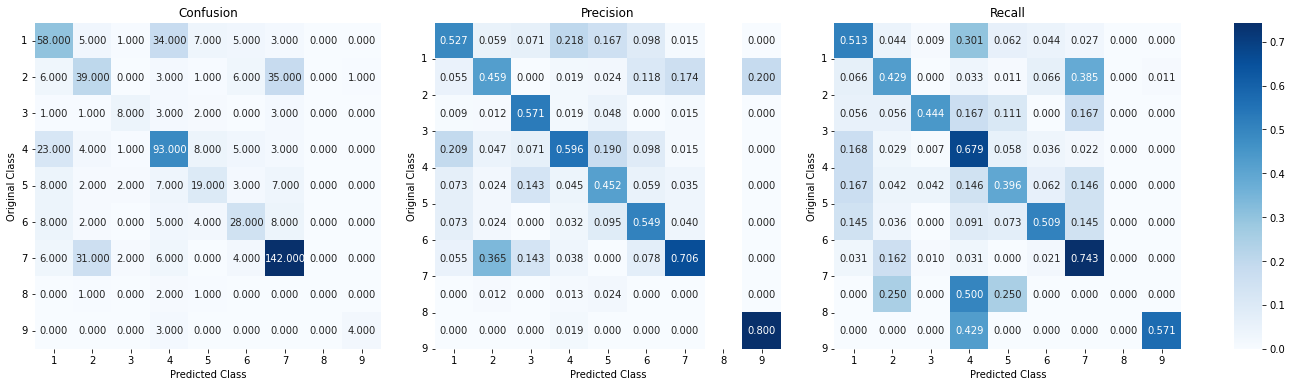

In [ ]:
plot_matrices(cnnmodel,XD_test, YD_test )

#### Plot Model loss and accuracy

In [ ]:
# list all data history 
print(hiscnn.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
# visualize training and validation losses  
plt.plot(hiscnn.history['loss'])
plt.plot(hiscnn.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

In [ ]:
# visualize training and validation accuracies
plt.plot(hiscnn.history['accuracy'])
plt.plot(hiscnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()